In [1]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.3.0                |     pyhd8ed1ab_0          68 KB  conda-forge
    openssl-1.1.1t             |       h0b41bf4_0         1.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.3 MB

The fo

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing th

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 12.2 MB/s eta 0:00:00
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.2.2               |     pyhd8ed1ab_0         544 KB  conda-forge
    attrs-22.2.0               |     pyh71513ae_0          53 KB  conda-forge
    branca-0.6.0               |     pyhd8ed1ab_0          27 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    importlib_resources-5.12.0 |     pyhd8

In [10]:
source = requests.get('https://en.wikipedia.org/wiki/Category:Areas_of_Manchester').text 
soup = BeautifulSoup(source, 'lxml')

In [11]:
csv_file = open('manchester.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighbourhood'])

15

In [12]:
mwcg = soup.find_all(class_ = "mw-category-group")

length = len(mwcg)

for i in range(1, length):
    lists = mwcg [i].find_all('a')
    for list in lists:
        nbd = list.get('title')
        csv_writer.writerow([nbd])

In [13]:
csv_file.close()

In [14]:
manchester_raw = pd.read_csv('manchester.csv')

In [15]:
manchester_raw.shape

(63, 1)

In [19]:
manchester_raw.head(10)

,Neighbourhood
0,Baguley
1,Barlow Moor
2,"Belle Vue, Manchester"
3,Benchill
4,"Beswick, Manchester"
5,Blackley
6,Bradford-with-Beswick
7,"Bradford, Manchester"
8,Brooklands (Manchester ward)
9,Burnage


In [20]:
lat = []
lng = []
lat_lng_coords = None

neighbourhoods = manchester_raw['Neighbourhood']

for nh in neighbourhoods:
    g = geocoder.arcgis('{}, Manchester, UK'.format(nh))
    lat_lng_coords = g.latlng
    lat.append(lat_lng_coords[0])
    lng.append(lat_lng_coords[1])

In [21]:
man_data = manchester_raw
man_data['Latitude'] = lat
man_data['Longitude'] = lng

In [24]:
man_data.head()

,Neighbourhood,Latitude,Longitude
0,Baguley,53.399432,-2.294060
1,Barlow Moor,53.426562,-2.266241
2,"Belle Vue, Manchester",53.463060,-2.197180
3,Benchill,53.389117,-2.265841
4,"Beswick, Manchester",53.483804,-2.215091


In [26]:
from geopy.geocoders import Nominatim

address = 'Manchester, UK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manchester are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manchester are 53.4794892, -2.2451148.


In [27]:
man_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(man_data['Latitude'], man_data['Longitude'], man_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(man_map)  
    
man_map

In [28]:
def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
explore_df_list = []

for i, nhood_name in enumerate(man_data['Neighbourhood']):  
    
    try :
        nhood_name = man_data.loc[i, 'Neighbourhood']
        nhood_lat = man_data.loc[i, 'Latitude']
        nhood_lng = man_data.loc[i, 'Longitude']

        radius = 1000 
        LIMIT = 30 

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nhood_lat, nhood_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results)

        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist() 
            f_list = [nhood_name, nhood_lat, nhood_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [30]:
explore_man = pd.DataFrame([item for item in explore_df_list])
explore_man.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_man.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Baguley,53.399432,-2.29406,Lidl,Supermarket,53.400455,-2.295649
1,Baguley,53.399432,-2.29406,B&M Store,Furniture / Home Store,53.401589,-2.299105
2,Baguley,53.399432,-2.29406,Costa Coffee,Coffee Shop,53.400795,-2.295027
3,Baguley,53.399432,-2.29406,McDonald's,Fast Food Restaurant,53.400461,-2.289088
4,Baguley,53.399432,-2.29406,Aldi,Supermarket,53.401268,-2.299659


In [32]:
man_1hot = pd.get_dummies(explore_man[['Venue Category']], prefix="", prefix_sep="")

man_1hot['Neighbourhood'] = explore_man['Neighbourhood'] 

fixed_columns = [man_1hot.columns[-1]] + man_1hot.columns[:-1].values.tolist()
man_1hot = man_1hot[fixed_columns]

man_1hot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Betting Shop,Bike Shop,Bike Trail,Bistro,Bookstore,Boutique,Bowling Green,Brazilian Restaurant,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Canal,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cricket Ground,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Donut Shop,Duty-free Shop,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Forest,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gay Bar,Gelato Shop,German Restaurant,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Newsagent,North Indian Restaurant,Optical Shop,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Polish Restaurant,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,Sandwich Place,Science Museum,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tour Provider,Toy / Game Store,Track Stadium,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yemeni Restaurant
0,Baguley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Baguley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Baguley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Baguley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Baguley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [33]:
man_grouped = man_1hot.groupby('Neighbourhood').mean().reset_index()
man_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Betting Shop,Bike Shop,Bike Trail,Bistro,Bookstore,Boutique,Bowling Green,Brazilian Restaurant,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Canal,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cricket Ground,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Donut Shop,Duty-free Shop,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Forest,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gay Bar,Gelato Shop,German Restaurant,Go Kart Track,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Newsagent,North Indian Restaurant,Optical Shop,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Polish Restaurant,Pool,Pop-Up Shop,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,Sandwich Place,Science Museum,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tour Provider,Toy / Game Store,Track Stadium,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yemeni Restaurant
0,Baguley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125,0.000000,0.062500,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0625,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062500,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0625,0.0625,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.062500,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.187500,0.0,0.0,0.0,0.000000,0.0,0.0
1,Barlow Moor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.071429,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.071429,0.071429,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.142857,0.071429,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.071429,0.0,0.071429,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.

In [34]:
def top_common_venues(row, top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

In [35]:
top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = man_grouped['Neighbourhood']

for ind in np.arange(man_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = top_common_venues(man_grouped.iloc[ind, :], top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baguley,Tram Station,Supermarket,Clothing Store,Coffee Shop,Gym / Fitness Center,Furniture / Home Store,Garden,Fast Food Restaurant,Soccer Stadium,Pet Store
1,Barlow Moor,Grocery Store,Hotel,Gym,Indian Restaurant,Park,Fast Food Restaurant,Fish & Chips Shop,Bus Station,Middle Eastern Restaurant,Golf Course
2,"Belle Vue, Manchester",Grocery Store,Convenience Store,Supermarket,Indian Restaurant,Dessert Shop,Electronics Store,Pharmacy,Racetrack,Restaurant,Park
3,Benchill,Tram Station,Pub,Supermarket,Market,Bus Station,Bakery,Bus Stop,Pharmacy,Pet Store,Movie Theater
4,"Beswick, Manchester",Coffee Shop,Bar,Beer Bar,Italian Restaurant,Cocktail Bar,Tour Provider,Brewery,Pizza Place,Gym / Fitness Center,Park


In [36]:
man_grouped_clustering = man_grouped.drop('Neighbourhood', 1)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [38]:
max_range = 15 

from sklearn.metrics import silhouette_samples, silhouette_score


indices = []
scores = []

for man_clusters in range(2, max_range) :
    
    man_gc = man_grouped_clustering
    kmeans = KMeans(n_clusters = man_clusters, init = 'k-means++', random_state = 0).fit_predict(man_gc)
    
    score = silhouette_score(man_gc, kmeans)
    
    indices.append(man_clusters)
    scores.append(score)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/jupyterlab/conda/e

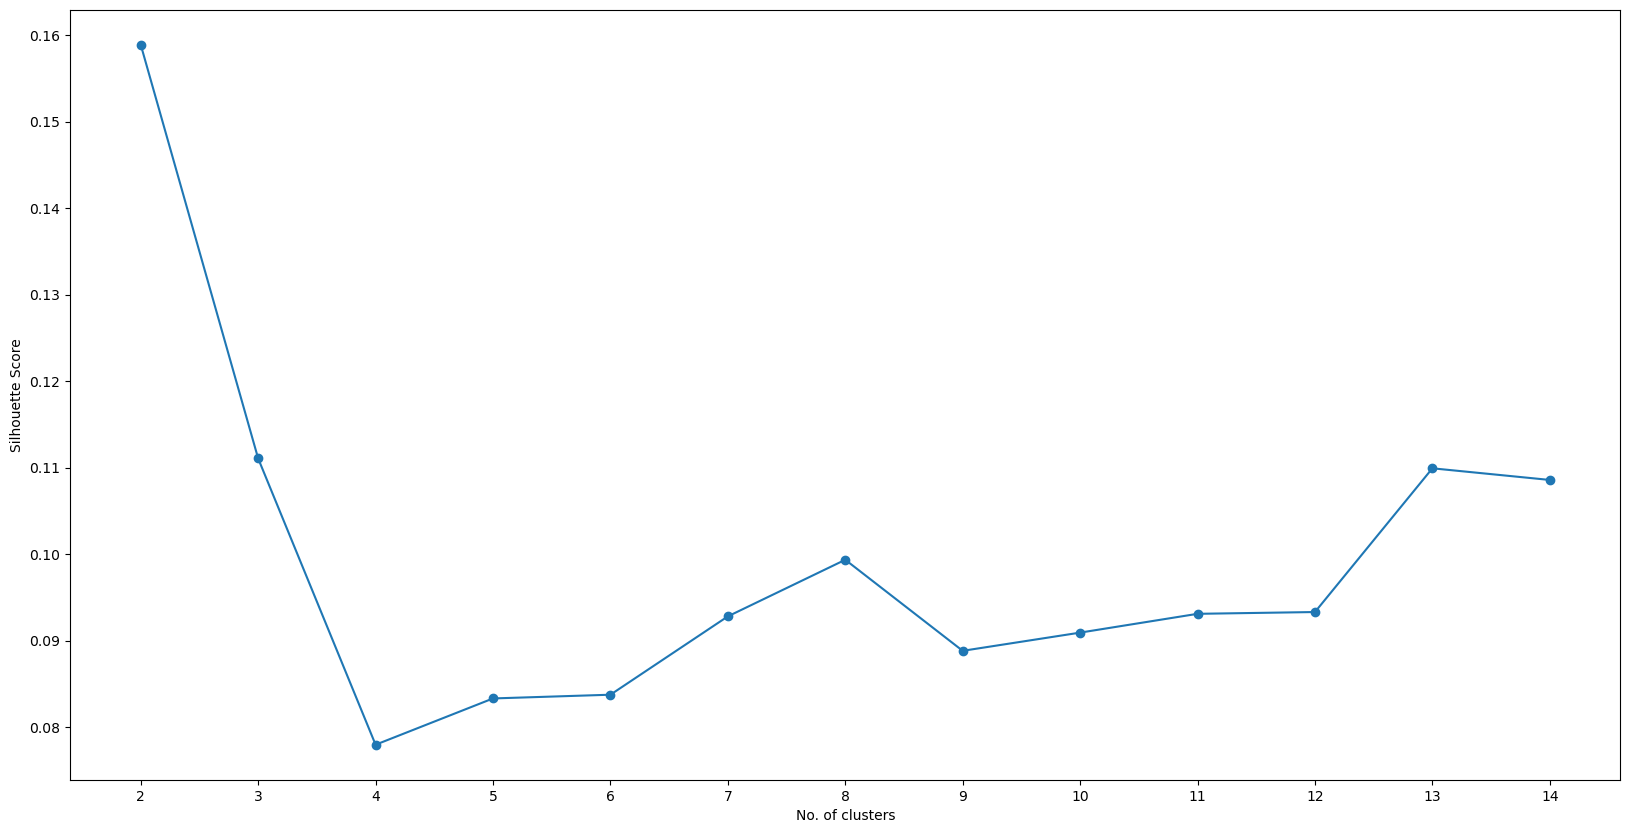

In [39]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [40]:
opt_value = 8

In [41]:
man_clusters = opt_value

man_gc = man_grouped_clustering
kmeans = KMeans(n_clusters = man_clusters, init = 'k-means++', random_state = 0).fit(man_gc)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/jupyterlab/conda/e

In [42]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [43]:
man_final = man_data
man_final = man_final.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
man_final.dropna(inplace = True)
man_final['Cluster Labels'] = man_final['Cluster Labels'].astype(int)
man_final.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baguley,53.399432,-2.294060,2,Tram Station,Supermarket,Clothing Store,Coffee Shop,Gym / Fitness Center,Furniture / Home Store,Garden,Fast Food Restaurant,Soccer Stadium,Pet Store
1,Barlow Moor,53.426562,-2.266241,4,Grocery Store,Hotel,Gym,Indian Restaurant,Park,Fast Food Restaurant,Fish & Chips Shop,Bus Station,Middle Eastern Restaurant,Golf Course
2,"Belle Vue, Manchester",53.463060,-2.197180,7,Grocery Store,Convenience Store,Supermarket,Indian Restaurant,Dessert Shop,Electronics Store,Pharmacy,Racetrack,Restaurant,Park
3,Benchill,53.389117,-2.265841,3,Tram Station,Pub,Supermarket,Market,Bus Station,Bakery,Bus Stop,Pharmacy,Pet Store,Movie Theater
4,"Beswick, Manchester",53.483804,-2.215091,1,Coffee Shop,Bar,Beer Bar,Italian Restaurant,Cocktail Bar,Tour Provider,Brewery,Pizza Place,Gym / Fitness Center,Park


In [49]:
area = 1
man_final.loc[man_final['Cluster Labels'] == (area - 1), man_final.columns[[0] + np.arange(4, man_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,New Moston,Hotel,Malay Restaurant,Convenience Store,Tram Station,Train Station,Pub,Supermarket,Soccer Stadium,Afghan Restaurant,Movie Theater


In [50]:
area = 2
man_final.loc[man_final['Cluster Labels'] == (area - 1), man_final.columns[[0] + np.arange(4, man_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Beswick, Manchester",Coffee Shop,Bar,Beer Bar,Italian Restaurant,Cocktail Bar,Tour Provider,Brewery,Pizza Place,Gym / Fitness Center,Park
6,Bradford-with-Beswick,Lounge,Tram Station,Athletics & Sports,Track Stadium,Bar,Gym,Sandwich Place,Canal,Café,Soccer Stadium
7,"Bradford, Manchester",Lounge,Tram Station,Athletics & Sports,Track Stadium,Bar,Gym,Sandwich Place,Canal,Café,Soccer Stadium
8,Brooklands (Manchester ward),Restaurant,Indian Restaurant,Hotel,Cocktail Bar,Pub,Burger Joint,Bar,Italian Restaurant,Theater,Concert Hall
11,Castlefield,Pub,Restaurant,Hotel,Bar,Japanese Restaurant,Cocktail Bar,Gastropub,Café,Multiplex,Music Venue
15,Chorlton-cum-Hardy,Pizza Place,Bar,Coffee Shop,Pub,Café,Park,Fish Market,Tapas Restaurant,Grocery Store,Gastropub
16,Chorlton-on-Medlock,Middle Eastern Restaurant,Café,Hookah Bar,Halal Restaurant,Indian Restaurant,Afghan Restaurant,Coffee Shop,Dessert Shop,Falafel Restaurant,Fast Food Restaurant
18,Circle Square Manchester,Pub,Indian Restaurant,Bakery,Café,Bar,Coffee Shop,Restaurant,Fast Food Restaurant,College Arts Building,Monument / Landmark
26,Green Quarter,Pub,Food Court,Coffee Shop,Music Venue,Department Store,Brewery,Bar,Gym / Fitness Center,Burger Joint,Mexican Restaurant
27,"Greenheys, Manchester",Music Venue,Bar,Café,Chinese Restaurant,Coffee Shop,Pool,Theater,Museum,Park,Supermarket


In [51]:
area = 3
man_final.loc[man_final['Cluster Labels'] == (val - 1), man_final.columns[[0] + np.arange(4, man_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Benchill,Tram Station,Pub,Supermarket,Market,Bus Station,Bakery,Bus Stop,Pharmacy,Pet Store,Movie Theater
19,"Clayton, Manchester",Discount Store,Tram Station,Supermarket,Pub,Gym / Fitness Center,Park,Coffee Shop,Bus Stop,Grocery Store,Gym
42,Newton Heath,Supermarket,Park,Tram Station,Canal,Fast Food Restaurant,Shoe Store,Athletics & Sports,Bus Stop,Gymnastics Gym,Pet Store
52,Sharston,Park,Bus Stop,Supermarket,Tram Station,Coffee Shop,Farm,Optical Shop,Multiplex,Museum,Music Venue
62,Wythenshawe,Pub,Tram Station,Bus Stop,Farm,Coffee Shop,Bar,Pharmacy,Pie Shop,Museum,Platform


In [52]:
area = 4
man_final.loc[man_final['Cluster Labels'] == (area - 1), man_final.columns[[0] + np.arange(4, man_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Benchill,Tram Station,Pub,Supermarket,Market,Bus Station,Bakery,Bus Stop,Pharmacy,Pet Store,Movie Theater
19,"Clayton, Manchester",Discount Store,Tram Station,Supermarket,Pub,Gym / Fitness Center,Park,Coffee Shop,Bus Stop,Grocery Store,Gym
42,Newton Heath,Supermarket,Park,Tram Station,Canal,Fast Food Restaurant,Shoe Store,Athletics & Sports,Bus Stop,Gymnastics Gym,Pet Store
52,Sharston,Park,Bus Stop,Supermarket,Tram Station,Coffee Shop,Farm,Optical Shop,Multiplex,Museum,Music Venue
62,Wythenshawe,Pub,Tram Station,Bus Stop,Farm,Coffee Shop,Bar,Pharmacy,Pie Shop,Museum,Platform
